<a href="https://colab.research.google.com/github/malcolmlett/robovac/blob/main/Experiment_SLAM_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment: SLAM (v2)
The first version was a bit of a mission to get to something working and it had so many side experiments. I now want to move forward with a clean baseline in order to make those improvements.

Here I'll focus on improving the loss functions and possibly tweak the data representations if needed.

I want to get to a point where the model trains as well as can be reasonable given the quality of the dataset.

In [1]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/robovac.git repo

# lock to revision
#!cd repo && git checkout db6fe3a
!cd repo && git pull

import sys
sys.path.append('repo')

from general_utils import display_history
import lds
import slam
import slam_data
from importlib import reload
reload(lds)
reload(slam)
reload(slam_data)

HEAD is now at 9d1d250 Listing raw adlo values
Already up to date.


<module 'slam_data' from '/content/repo/slam_data.py'>

In [2]:
!pip install -Uqq ipdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import io
import os
import shutil
import tarfile
import cv2
import requests
import math
import ipdb
import tqdm
import time
from timeit import default_timer as timer

## Training data


In [3]:
# If generated data is available then load that to save time:
train_data = slam_data.load_dataset('repo/data/experimental-slam-training-data1.npz')
slam_data.validate_dataset(train_data)

Loaded:
  input_maps:        (1000, 149, 149, 3)
  lds_maps:          (1000, 149, 149)
  ground_truth_maps: (1000, 149, 149, 3)
  adlos:             (1000, 4)
Dataset loaded from repo/data/experimental-slam-training-data1.npz
Dataset tests passed (1000 entries verified)


In [4]:
# Alternatively, generate new data
#np.random.seed(0)
#train_data = generate_training_data(floorplan, 1000)
#train_data = slam_data.generate_training_data(floorplan, 1000, sample_types=[1])
#slam_data.validate_dataset(train_data)

In [5]:
# Uncomment to save dataset
#save_dataset(train_data, 'experimental-slam-training-data1-type1only.npz')

In [6]:
#slam_data.show_dataset(train_data, 5)

## Model Training

In [12]:
# Custom loss functions
# (out-of-the-box the two outputs get losses calculated independently,
#  ultimately I'll be wanting to conditionally choose whether the map loss
#  is considered depending on how the network is being used.
#  The easiest way to do that will be to generate the dataset so that the ground_truth_map
#  is blank for those cases)

def adlo_loss(y_true, y_pred):
    """
    y_true: (B,4), scaled
    y_pred: (B,4), logits
    """
    y_true = tf.cast(y_true, tf.float32)

    # binary cross-entropy loss for accept
    accept_true = y_true[:, 0]
    accept_pred = y_pred[:, 0]
    accept_losses = tf.keras.losses.binary_crossentropy(accept_true, accept_pred, from_logits=True)

    # log-cosh loss for delta x, y, orientation
    dlo_true = y_true[:, 1:4]
    delta_x = tf.math.tanh(y_pred[:, 1]) * 0.5  # -0.5 .. +0.5
    delta_y = tf.math.tanh(y_pred[:, 2]) * 0.5  # -0.5 .. +0.5
    delta_angle = tf.math.tanh(y_pred[:, 3])    # -1.0 .. +1.0
    dlo_pred = tf.stack([delta_x, delta_y, delta_angle], axis=1)
    dlo_losses = tf.reduce_mean(tf.math.log(tf.cosh(y_pred - y_true)))

    return accept_losses + dlo_losses

def adlo_loss1(y_true, y_pred):
    """
    y_true: (B,4), scaled
    y_pred: (B,4), logits
    """
    y_true = tf.cast(y_true, tf.float32)
    # scale logits to correct ranges
    accept_true = y_true[:, 0]
    #accept_pred = tf.nn.sigmoid(y_pred[:, 0])

    #accept_pred = tf.nn.sigmoid(y_pred[:, 0])
    #losses = tf.keras.losses.MSE(accept_true, accept_pred)
    #losses = tf.keras.losses.binary_crossentropy(accept_true, accept_pred, from_logits=False)
    print(f"y_true: {y_true.shape}, y_pred: {y_pred.shape}")

    #accept_pred = y_pred[:, 0]
    accept_pred = tf.gather(y_pred, 0, axis=1)

    losses = tf.keras.losses.binary_crossentropy(accept_true, accept_pred, from_logits=True)
    #print(f"accept_true: {accept_true.shape}, accept_pred: {accept_pred.shape}, losses: {losses.shape}")
    #print(f"accept_true ({accept_true.dtype}): {accept_true[0:10]}")
    #print(f"accept_pred ({accept_pred.dtype}): {accept_pred[0:10]}")
    #print(f"accept_pred: {tf.nn.sigmoid(accept_pred[0:10])}")
    #print(f"losses:     ({losses.dtype}) {losses}")

    #lg = tf.math.log(tf.nn.sigmoid(accept_pred))
    #bce = -tf.multiply(accept_true, tf.math.log(tf.nn.sigmoid(accept_pred))) - tf.multiply(1-accept_true, tf.math.log(1-tf.nn.sigmoid(accept_pred)))
    #print(f"log:         {lg[0:10]}")
    #print(f"derivation:  {tf.reduce_mean(bce)} <- {bce[0:10]}")

    return tf.reduce_mean(losses)

def accept_accuracy(y_true, y_pred):
    accept_true = tf.cast(y_true[:, 0], tf.float32)
    accept_pred = tf.cast(tf.round(tf.nn.sigmoid(y_pred[:, 0])), tf.float32)
    matches = tf.equal(accept_true, accept_pred)
    return tf.reduce_mean(tf.cast(matches, tf.float32))

def loc_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    loc_true = y_true[:, 1:3]
    loc_pred = tf.math.tanh(y_pred[:, 1:3]) * 0.5  # -0.5 .. +0.5
    losses = tf.math.sqrt(tf.keras.losses.MSE(loc_true, loc_pred))
    return tf.reduce_mean(losses)

def orientation_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    angle_true = y_true[:, 3]
    angle_pred = tf.math.tanh(y_pred[:, 3])  # -1.0 .. +1.0
    losses = tf.math.sqrt(tf.keras.losses.MSE(angle_true, angle_pred))
    return tf.reduce_mean(losses)

reload(slam)
reload(slam_data)
one = next(iter(train_data))
map_shape = one[0][0].shape
print(f"map_shape: {map_shape}")
np.random.seed(42)
tf.random.set_seed(42)

model = slam.slam_model(map_shape, conv_filters=32, adlo_units=256)
model.compile(optimizer='adam',
              #run_eagerly=True,
              loss={
                  'map_output': tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  'adlo_output': adlo_loss
              },
              metrics={
                  'map_output': [tf.keras.metrics.CategoricalCrossentropy(from_logits=True, name='map_loss'), 'accuracy'],
                  'adlo_output': [adlo_loss, accept_accuracy, loc_error, orientation_error]
              })

epochs = 200
batch_size = 32
model_train_data = train_data.shuffle(buffer_size=len(train_data)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

start = timer()
model_history = model.fit(model_train_data, epochs=epochs)
duration = (timer() - start)
print(f"Epochs: {epochs}, duration: {duration} sec")
display_history(model_history)
slam_data.show_predictions(model, train_data, 5, show_classes='pred')

map_shape: (149, 149, 3)
Added final cropping layer: w=11, h=11
Prepared SLAM model
  Map shape:        (149, 149, 3) + padding (11, 11, 0)
  Skip-connections: concat
  Output scaling:   logits
  Inputs:           [<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=None, name=map_input>, <KerasTensor shape=(None, 149, 149), dtype=float32, sparse=None, name=lds_input>]
  Outputs:          [<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=False, name=keras_tensor_336>, <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_341>]
Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - adlo_output_accept_accuracy: 0.6860 - adlo_output_adlo_loss: 1.4048 - adlo_output_loc_error: 0.1427 - adlo_output_orientation_error: 0.4056 - loss: 2.1415 - map_output_accuracy: 0.6719 - map_output_map_loss: 0.7362
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 397ms/step - adlo_output_accept_accuracy: 0.7431 - adlo_output_adlo_loss: 0.6127 - adlo_output_loc_error: 0.08

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [1.6613222  0.00907272 0.0019305  0.00192727]
adlo-pred scaled: [0.8404154  0.00453623 0.00096525 0.00192726]


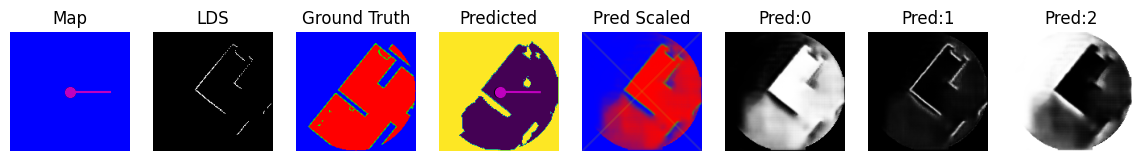

adlo:             [0. 0. 0. 0.]
adlo-pred raw:    [-0.9797245  -0.02546233 -0.01076715 -0.01406029]
adlo-pred scaled: [ 0.27294645 -0.01272841 -0.00538336 -0.01405937]


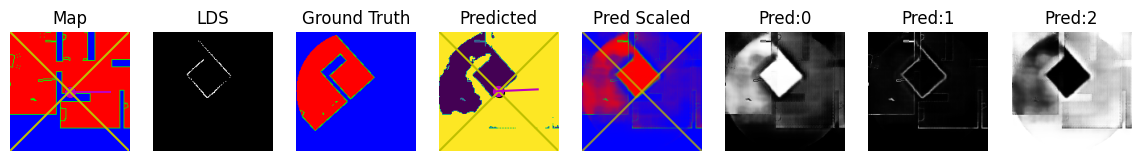

adlo:             [ 1.          0.33607876 -0.16260384  0.29634374]
adlo-pred raw:    [ 1.8278269   0.01571232 -0.03388625 -0.04502445]
adlo-pred scaled: [ 0.86150265  0.00785551 -0.01693664 -0.04499405]


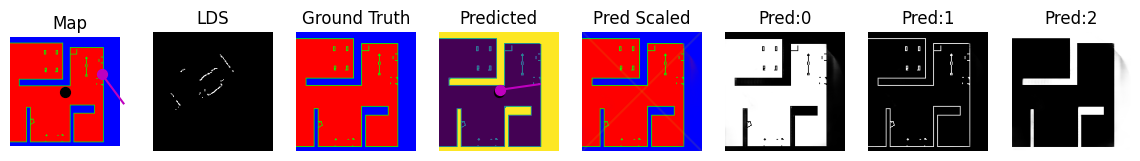

adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 1.6862332  -0.01288477 -0.01643987  0.04727738]
adlo-pred scaled: [ 0.8437282  -0.00644203 -0.00821919  0.04724219]


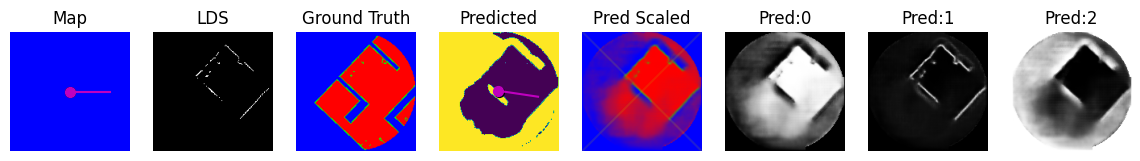

adlo:             [1.         0.17887953 0.22063265 0.16403958]
adlo-pred raw:    [ 1.7858998   0.00386169 -0.04005907  0.10940459]
adlo-pred scaled: [ 0.85642385  0.00193084 -0.02001882  0.10897017]


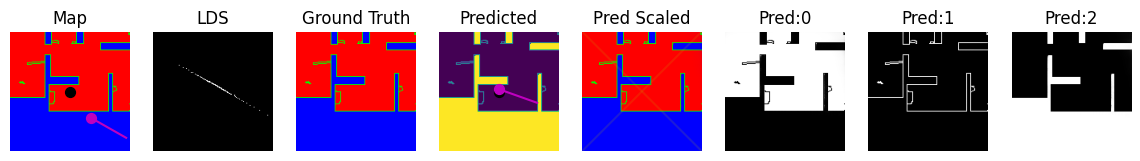

adlo:             [ 1.          0.04322181 -0.03710825  0.04561503]
adlo-pred raw:    [ 1.6157794  -0.02069019 -0.04634684  0.09123128]
adlo-pred scaled: [ 0.83421224 -0.01034362 -0.02315684  0.090979  ]


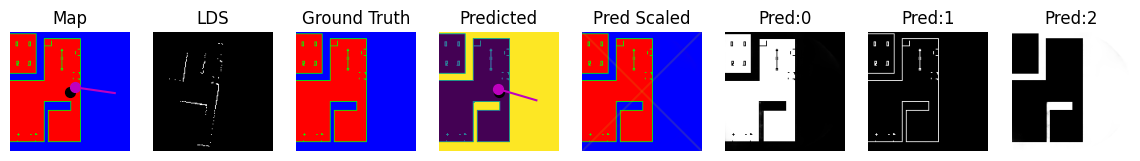

adlo:             [ 1.         -0.27767861 -0.11351102  0.80519695]
adlo-pred raw:    [ 1.941882   -0.16780658 -0.10834746  0.3660081 ]
adlo-pred scaled: [ 0.8745587  -0.0831245  -0.05396273  0.3504951 ]


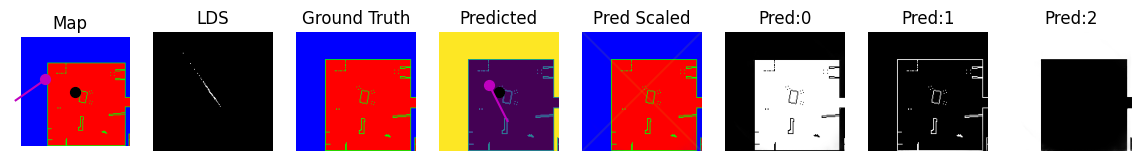

adlo:             [ 1.         -0.43977453  0.16676672  0.34127574]
adlo-pred raw:    [ 1.8193706   0.00660357 -0.0980953   0.0393552 ]
adlo-pred scaled: [ 0.8604906   0.00330174 -0.04889093  0.03933489]


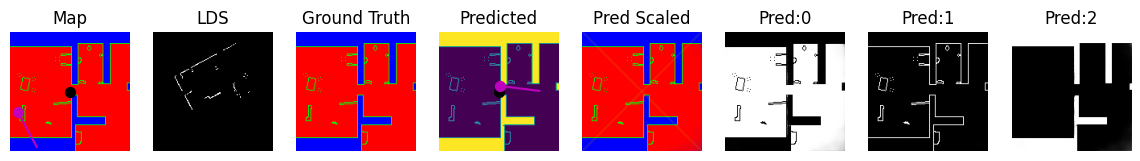

adlo:             [ 1.         -0.17495277 -0.46157457  0.26854812]
adlo-pred raw:    [ 1.7725523  -0.08888412 -0.14297254 -0.09766554]
adlo-pred scaled: [ 0.85477483 -0.04432539 -0.07100313 -0.09735618]


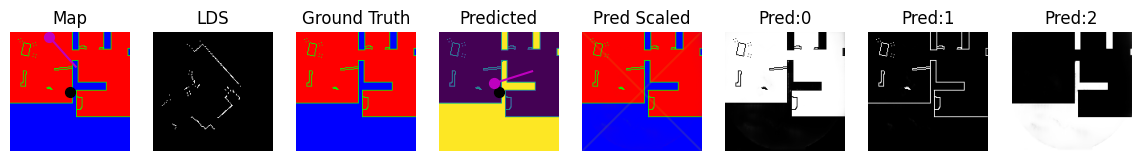

adlo:             [ 1.          0.15310833 -0.2467084  -0.06737845]
adlo-pred raw:    [1.698684   0.10694201 0.00179727 0.15361227]
adlo-pred scaled: [0.84536284 0.05326808 0.00089863 0.1524153 ]


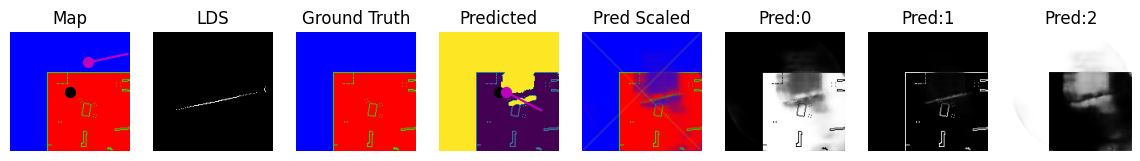

adlo:             [0. 0. 0. 0.]
adlo-pred raw:    [-0.8222892  -0.05416337  0.04213293 -0.02656265]
adlo-pred scaled: [ 0.30527794 -0.02705523  0.02105401 -0.02655641]


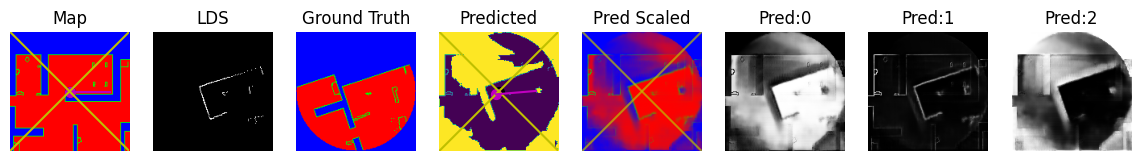

adlo:             [0. 0. 0. 0.]
adlo-pred raw:    [-1.2125727   0.00857439  0.00523746  0.04906512]
adlo-pred scaled: [0.22924614 0.00428709 0.00261871 0.04902578]


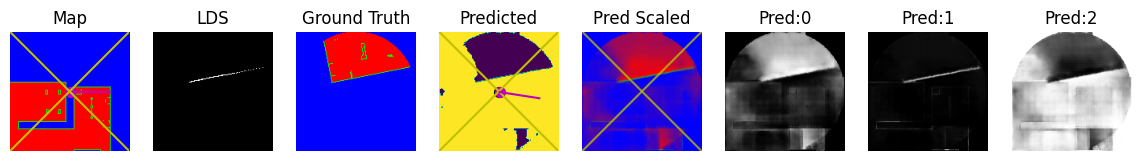

adlo:             [ 1.          0.01839872 -0.00223619  0.03594445]
adlo-pred raw:    [ 1.7831242  -0.07837827 -0.03937574  0.09323046]
adlo-pred scaled: [ 0.8560822  -0.03910908 -0.0196777   0.09296127]


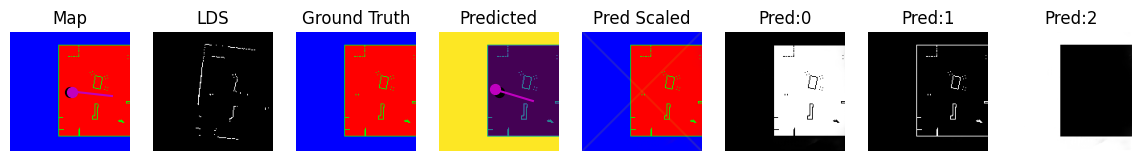

adlo:             [0. 0. 0. 0.]
adlo-pred raw:    [-0.99972856 -0.05258361  0.0233644   0.02488248]
adlo-pred scaled: [ 0.26899478 -0.02626759  0.01168007  0.02487734]


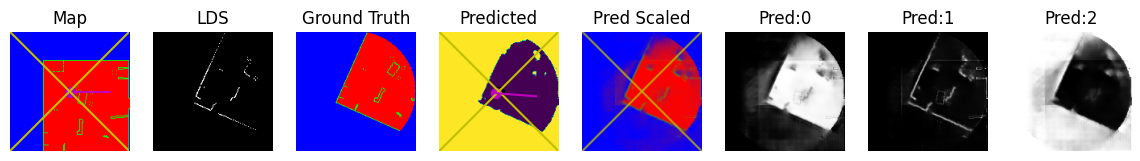

adlo:             [ 1.00000000e+00 -1.12019390e-02 -2.10091695e-02  9.35670486e-04]
adlo-pred raw:    [ 1.7593626   0.01410108 -0.06656888  0.11620457]
adlo-pred scaled: [ 0.8531298   0.00705007 -0.03323536  0.1156843 ]


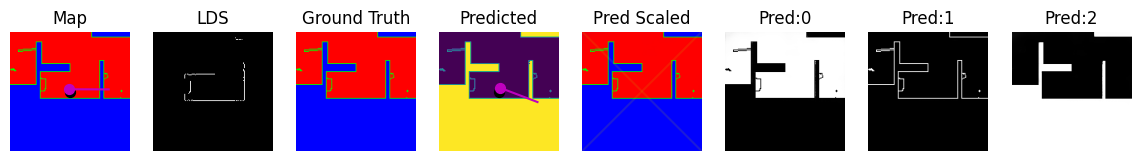

adlo:             [ 1.         -0.31680864  0.08651293 -0.95978491]
adlo-pred raw:    [ 1.8125436   0.0216475   0.01433923 -0.18783371]
adlo-pred scaled: [ 0.859669    0.01082206  0.00716912 -0.18565543]


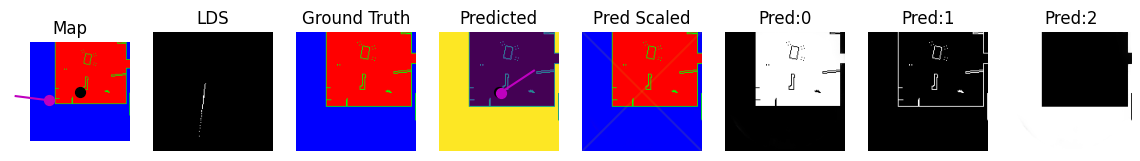

adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 1.6325089   0.01283955 -0.01249488  0.00534758]
adlo-pred scaled: [ 0.83651304  0.00641942 -0.00624711  0.00534753]


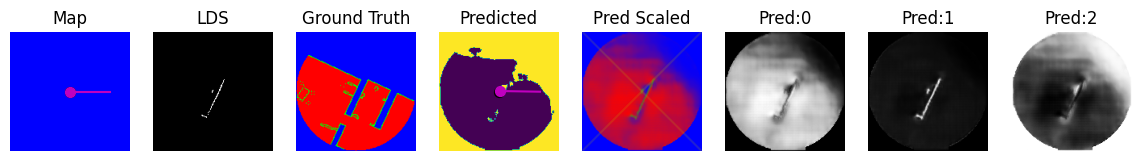

adlo:             [1.         0.07615733 0.09204193 0.14450381]
adlo-pred raw:    [ 1.7995864  -0.02306335 -0.01187888  0.11319505]
adlo-pred scaled: [ 0.8580986  -0.01152963 -0.00593916  0.11271404]


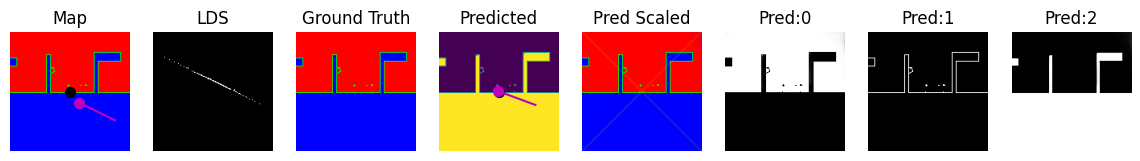

adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 1.7068608   0.01939675 -0.0257315   0.0346595 ]
adlo-pred scaled: [ 0.84642863  0.00969716 -0.01286291  0.03464562]


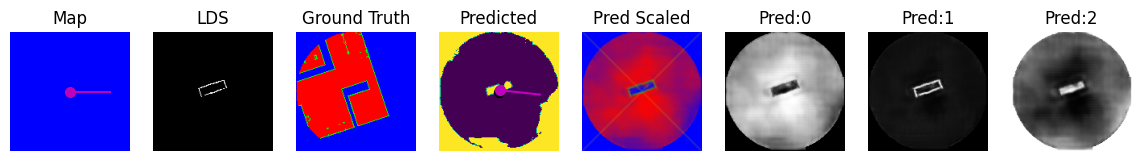

adlo:             [0. 0. 0. 0.]
adlo-pred raw:    [-1.3923938  -0.06100006 -0.02349189  0.03166276]
adlo-pred scaled: [ 0.19902588 -0.03046226 -0.01174378  0.03165218]


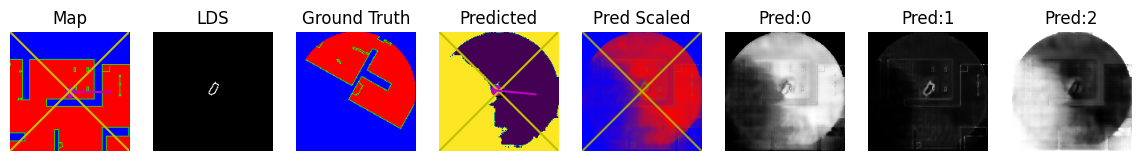

In [14]:
slam_data.show_predictions(model, train_data, 20, show_classes='pred')

In [15]:
# save model to disk for getting back into this later
model.save('experimental-slam-model1-100epochs.keras')

# ...or relead
#unet = tf.keras.models.load_model('experimental-slam-model1-200epochs.keras')

## Learnings

* ADLO Accept
  * All indications are that the loss function is correctly calculating the right value. I have to assume that it also translates into appropriate gradients. So I have to assume for now that the problem is just that the ADLO part of the network actually has a tough job and it'll need a lot more training to get there.